  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
<c

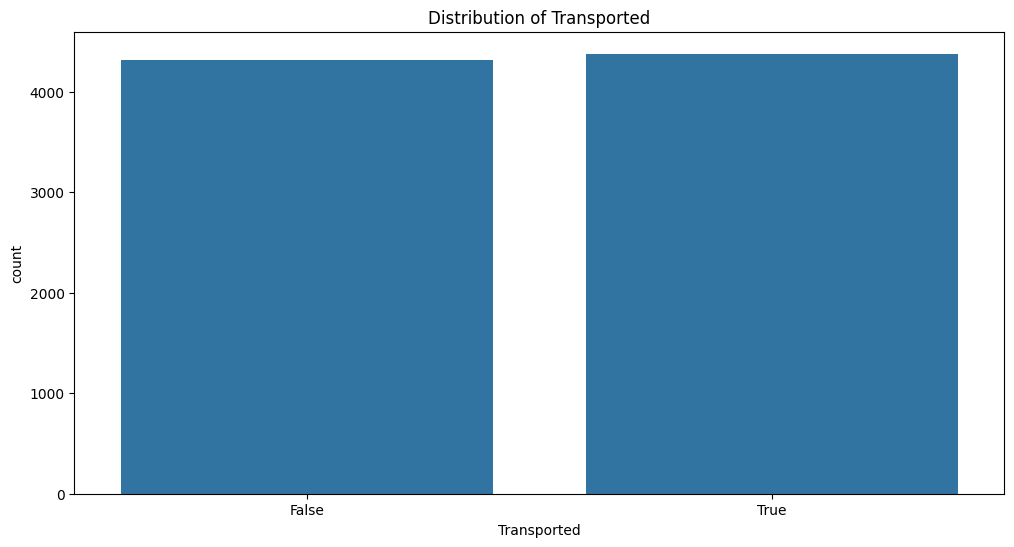

ValueError: could not convert string to float: 'Earth'

In [1]:
# Spaceship Titanic Lab Solution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the data
train_data = pd.read_csv("train_Lab3.csv")
test_data = pd.read_csv("test_Lab3.csv")

# Data Exploration
print(train_data.head())
print(train_data.info())
print(train_data.isnull().sum())

# Data Visualization
plt.figure(figsize=(12, 6))
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Transported')
plt.show()

# Feature Engineering
for df in [train_data, test_data]:
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['TotalSpending'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Prepare data for modeling
X = train_data.drop(['Transported', 'PassengerId', 'Name', 'Cabin', 'Group'], axis=1)
y = train_data['Transported'].astype(int)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column types
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'TotalSpending', 'Num']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a preprocessing and modeling pipeline
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# CatBoost can handle categorical variables directly, so we'll use a different approach
cat_features = categorical_features
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, cat_features=cat_features, verbose=0, random_state=42)

# Model Training and Evaluation
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "CatBoost": catboost_model
}

for name, model in models.items():
    if name != "CatBoost":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    else:
        model.fit(X_train, y_train, cat_features=cat_features)
        y_pred = model.predict(X_val)
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))
    print("\n")

# Choose the best model (for this example, let's assume XGBoost performed best)
best_model = xgb_model
best_model.fit(X, y)  # Train on full training data

# Prepare test data
X_test = test_data.drop(['PassengerId', 'Name', 'Cabin', 'Group'], axis=1)

# Make predictions on test data
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Transported': test_predictions.astype(bool)
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")